# Мультиклассовая классификация: лоссы, метрики и методы работы с дисбалансом

Исследование различных подходов к мультиклассовой классификации, включая функции потерь, метрики с различными типами усреднения, методы работы с дисбалансом классов и label smoothing.


In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchmetrics.classification import (
    Accuracy, Precision, Recall, F1Score,
    ConfusionMatrix
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.utils import compute_class_weight
from wine_quality_data import WineQualityDataModule
from mlp_model import MLPClassifier
from lightning_module import BaseLightningModule
from utils import set_seed
from pytorch_lightning import Trainer

sns.set_style("whitegrid")
set_seed(42)


## 1. Разница между CrossEntropyLoss и NLLLoss

**NLLLoss (Negative Log Likelihood Loss)** вычисляет потерю от логарифмов вероятностей:

$$L_{NLL} = -\frac{1}{N}\sum_{i=1}^{N}\log(p_{i,y_i})$$

где $p_{i,y_i}$ - вероятность правильного класса для примера $i$, полученная после применения softmax.

**CrossEntropyLoss** объединяет LogSoftmax и NLLLoss в одну операцию:

$$L_{CE} = -\frac{1}{N}\sum_{i=1}^{N}\log\left(\frac{\exp(z_{i,y_i})}{\sum_{j=1}^{C}\exp(z_{i,j})}\right)$$

где $z_{i,j}$ - логит для класса $j$ примера $i$, $C$ - количество классов.

Преимущества CrossEntropyLoss:
- Численная стабильность: избегает проблем с переполнением при вычислении softmax
- Вычислительная эффективность: объединенная операция быстрее
- Более точные градиенты за счет численной оптимизации


Логиты:
tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863],
        [ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094]], requires_grad=True)

Целевые классы: tensor([2, 1, 2, 0])

Потери по примерам:
  NLLLoss: [1.101067  2.0042946 1.9555402 1.3928273]
  CrossEntropyLoss: [1.101067  2.0042946 1.9555402 1.3928273]

Разница: 0.00e+00


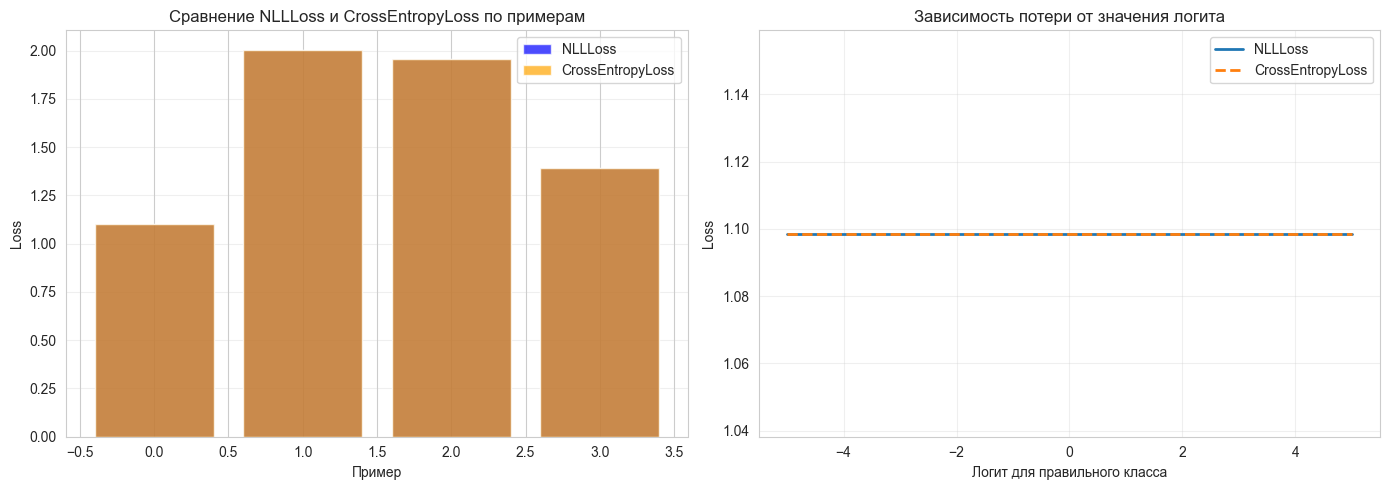

In [2]:
n_classes = 3
batch_size = 4
logits = torch.randn(batch_size, n_classes, requires_grad=True)

targets = torch.randint(0, n_classes, (batch_size,))

ce_loss = nn.CrossEntropyLoss(reduction='none')
nll_loss = nn.NLLLoss(reduction='none')
log_softmax = nn.LogSoftmax(dim=1)

probs_log = log_softmax(logits)
loss_nll = nll_loss(probs_log, targets)
loss_ce = ce_loss(logits, targets)

print(f"Логиты:\n{logits}")
print(f"\nЦелевые классы: {targets}")
print(f"\nПотери по примерам:")
print(f"  NLLLoss: {loss_nll.detach().numpy()}")
print(f"  CrossEntropyLoss: {loss_ce.detach().numpy()}")
print(f"\nРазница: {torch.max(torch.abs(loss_nll - loss_ce)).item():.2e}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(range(batch_size), loss_nll.detach().numpy(), alpha=0.7, label='NLLLoss', color='blue')
axes[0].bar(range(batch_size), loss_ce.detach().numpy(), alpha=0.7, label='CrossEntropyLoss', color='orange')
axes[0].set_xlabel('Пример')
axes[0].set_ylabel('Loss')
axes[0].set_title('Сравнение NLLLoss и CrossEntropyLoss по примерам')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

logits_range = torch.linspace(-5, 5, 100).unsqueeze(1).repeat(1, n_classes)
logits_range = logits_range.requires_grad_(True)
target_fixed = torch.zeros(100, dtype=torch.long)

loss_nll_range = nll_loss(log_softmax(logits_range), target_fixed)
loss_ce_range = ce_loss(logits_range, target_fixed)

axes[1].plot(logits_range[:, 0].detach().numpy(), loss_nll_range.detach().numpy(), 
            label='NLLLoss', linewidth=2)
axes[1].plot(logits_range[:, 0].detach().numpy(), loss_ce_range.detach().numpy(), 
            label='CrossEntropyLoss', linewidth=2, linestyle='--')
axes[1].set_xlabel('Логит для правильного класса')
axes[1].set_ylabel('Loss')
axes[1].set_title('Зависимость потери от значения логита')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Метрики мультиклассовой классификации и их усреднения

В мультиклассовой классификации метрики можно усреднять тремя способами:

**Macro-averaging**: вычисляет метрику для каждого класса отдельно, затем усредняет:

$$Metric_{macro} = \frac{1}{C}\sum_{i=1}^{C}Metric_i$$

где $C$ - количество классов, $Metric_i$ - значение метрики для класса $i$.

**Micro-averaging**: вычисляет метрику глобально по всем примерам:

$$Metric_{micro} = \frac{\sum_{i=1}^{C}TP_i}{\sum_{i=1}^{C}(TP_i + FP_i)}$$

где $TP_i$ и $FP_i$ - True Positives и False Positives для класса $i$.

**Weighted-averaging**: усредняет метрики по классам с учетом их частоты:

$$Metric_{weighted} = \frac{1}{N}\sum_{i=1}^{C}n_i \cdot Metric_i$$

где $n_i$ - количество примеров класса $i$, $N$ - общее количество примеров.

**Accuracy**: доля правильно классифицированных примеров

$$Accuracy = \frac{1}{N}\sum_{i=1}^{N}\mathbb{1}(\hat{y}_i = y_i)$$

**Precision**: точность предсказаний для каждого класса

$$Precision_i = \frac{TP_i}{TP_i + FP_i}$$

**Recall**: полнота для каждого класса

$$Recall_i = \frac{TP_i}{TP_i + FN_i}$$

**F1 Score**: гармоническое среднее Precision и Recall

$$F1_i = 2 \cdot \frac{Precision_i \cdot Recall_i}{Precision_i + Recall_i}$$


## 3. Обучение модели на CrossEntropyLoss

Обучим модель мультиклассовой классификации на датасете Wine Quality с использованием CrossEntropyLoss. Модель будет предсказывать качество вина.

Используем MLP классификатор с несколькими скрытыми слоями и dropout для регуляризации.

CrossEntropyLoss является стандартным выбором для мультиклассовой классификации, так как он численно стабилен и эффективен.


In [3]:
data_module = WineQualityDataModule(batch_size=64, val_split=0.2, random_state=42)
data_module.setup()

print(f"Количество классов: {data_module.n_classes}")
print(f"Размерность входных данных: {data_module.input_dim}")

model = MLPClassifier(
    input_dim=data_module.input_dim,
    n_classes=data_module.n_classes,
    hidden_dims=[128, 64, 32],
    activation='relu',
    dropout=0.3
)

loss_fn = nn.CrossEntropyLoss()

lightning_module = BaseLightningModule(
    model=model,
    loss_fn=loss_fn,
    optimizer_type='adam',
    learning_rate=1e-3,
    task_type='multiclass'
)

trainer = Trainer(
    max_epochs=20,
    enable_progress_bar=True,
    enable_model_summary=True
)

trainer.fit(lightning_module, data_module)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Количество классов: 6
Размерность входных данных: 11


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | MLPClassifier    | 12.1 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
2 | metrics | ModuleDict       | 0      | train
-----------------------------------------------------
12.1 K    Trainable params
0         Non-trainable params
12.1 K    Total params
0.048     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.1719, f1_macro=0.1005


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: accuracy=0.3527, f1_macro=0.1021


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: accuracy=0.4206, f1_macro=0.1445


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: accuracy=0.4540, f1_macro=0.1652


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: accuracy=0.4737, f1_macro=0.1743


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: accuracy=0.4890, f1_macro=0.1811


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: accuracy=0.5024, f1_macro=0.1943


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: accuracy=0.5135, f1_macro=0.2091


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: accuracy=0.5212, f1_macro=0.2159


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: accuracy=0.5286, f1_macro=0.2203


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: accuracy=0.5349, f1_macro=0.2265


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: accuracy=0.5408, f1_macro=0.2346


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11: accuracy=0.5461, f1_macro=0.2392


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12: accuracy=0.5511, f1_macro=0.2445


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13: accuracy=0.5556, f1_macro=0.2491


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14: accuracy=0.5578, f1_macro=0.2514


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15: accuracy=0.5591, f1_macro=0.2508


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16: accuracy=0.5625, f1_macro=0.2540


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17: accuracy=0.5649, f1_macro=0.2554


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18: accuracy=0.5668, f1_macro=0.2552


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: accuracy=0.5674, f1_macro=0.2536


Вычисляем метрики на валидационной выборке с различными типами усреднения и сравниваем их значения.


Accuracy: 0.5781

Precision:
  Macro: 0.1929
  Micro: 0.5781
  Weighted: 0.4788

Recall:
  Macro: 0.2330
  Micro: 0.5781
  Weighted: 0.5781

F1 Score:
  Macro: 0.2111
  Micro: 0.5781
  Weighted: 0.5238


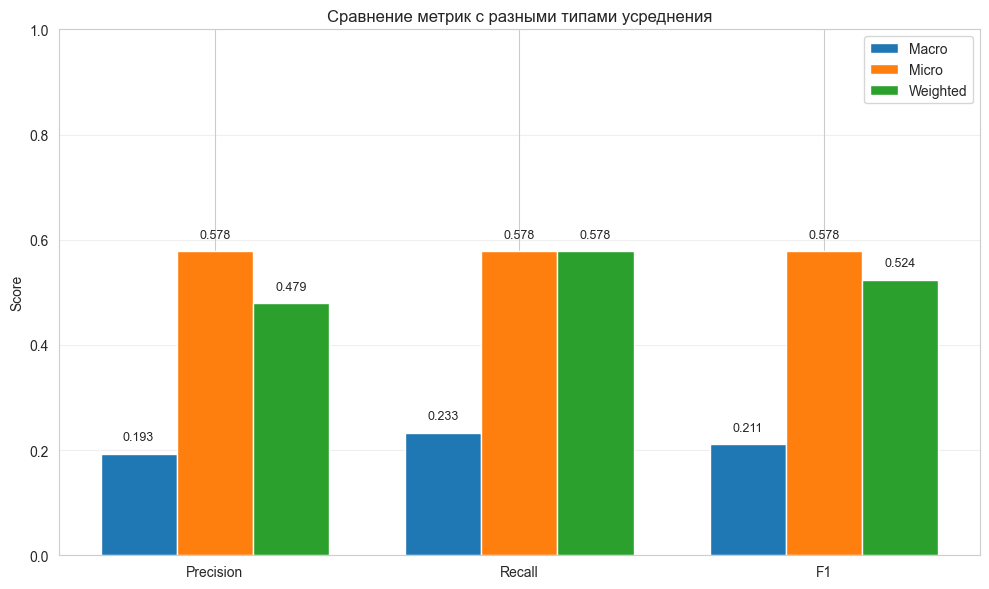

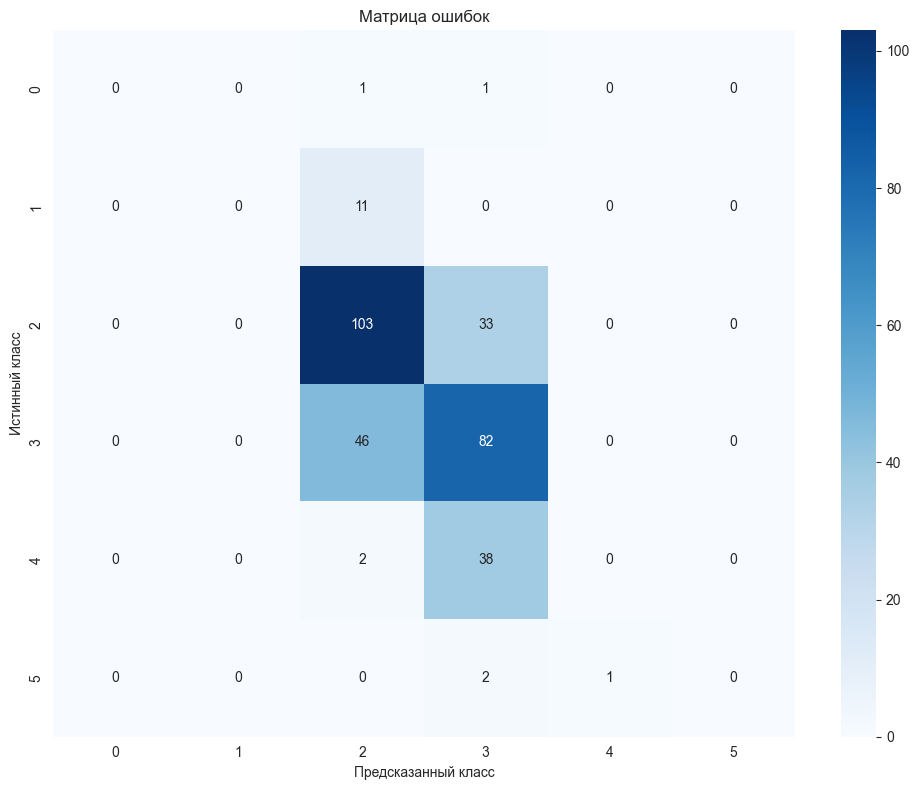

In [4]:
lightning_module.eval()
model.eval()

y_true_all = []
y_pred_all = []

with torch.no_grad():
    for batch in data_module.val_dataloader():
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)
        y_true_all.append(y.numpy())
        y_pred_all.append(preds.numpy())

y_true = np.concatenate(y_true_all)
y_pred = np.concatenate(y_pred_all)

accuracy = accuracy_score(y_true, y_pred)
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
precision_weighted = precision_score(y_true, y_pred, average='weighted', zero_division=0)

recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
recall_micro = recall_score(y_true, y_pred, average='micro', zero_division=0)
recall_weighted = recall_score(y_true, y_pred, average='weighted', zero_division=0)

f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"\nPrecision:")
print(f"  Macro: {precision_macro:.4f}")
print(f"  Micro: {precision_micro:.4f}")
print(f"  Weighted: {precision_weighted:.4f}")

print(f"\nRecall:")
print(f"  Macro: {recall_macro:.4f}")
print(f"  Micro: {recall_micro:.4f}")
print(f"  Weighted: {recall_weighted:.4f}")

print(f"\nF1 Score:")
print(f"  Macro: {f1_macro:.4f}")
print(f"  Micro: {f1_micro:.4f}")
print(f"  Weighted: {f1_weighted:.4f}")

metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1'],
    'Macro': [precision_macro, recall_macro, f1_macro],
    'Micro': [precision_micro, recall_micro, f1_micro],
    'Weighted': [precision_weighted, recall_weighted, f1_weighted]
})

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
x = np.arange(len(metrics_df))
width = 0.25
ax.bar(x - width, metrics_df['Macro'], width, label='Macro', color='#1f77b4')
ax.bar(x, metrics_df['Micro'], width, label='Micro', color='#ff7f0e')
ax.bar(x + width, metrics_df['Weighted'], width, label='Weighted', color='#2ca02c')
ax.set_ylabel('Score')
ax.set_title('Сравнение метрик с разными типами усреднения')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Metric'])
ax.legend()
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')

for i, metric in enumerate(metrics_df['Metric']):
    ax.text(i - width, metrics_df.loc[i, 'Macro'] + 0.02, f'{metrics_df.loc[i, "Macro"]:.3f}', 
           ha='center', va='bottom', fontsize=9)
    ax.text(i, metrics_df.loc[i, 'Micro'] + 0.02, f'{metrics_df.loc[i, "Micro"]:.3f}', 
           ha='center', va='bottom', fontsize=9)
    ax.text(i + width, metrics_df.loc[i, 'Weighted'] + 0.02, f'{metrics_df.loc[i, "Weighted"]:.3f}', 
           ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.tight_layout()
plt.show()


## 4. Анализ дисбаланса классов

Перед применением методов работы с дисбалансом, важно оценить степень дисбаланса в данных.

**Дисбаланс классов** в мультиклассовой задаче может быть более сложным, чем в бинарной, так как некоторые классы могут быть представлены значительно меньше других.

**Метрики дисбаланса:**
- Распределение классов: количество примеров каждого класса
- Коэффициент вариации: $\frac{\sigma(n_i)}{\bar{n}}$, где $\sigma(n_i)$ - стандартное отклонение количества примеров по классам, $\bar{n}$ - среднее количество примеров

Проанализируем распределение классов в обучающей выборке.


Распределение классов в обучающей выборке:
  Всего классов: 6
  Всего примеров: 1279
  Класс 0: 8 примеров (0.63%)
  Класс 1: 42 примеров (3.28%)
  Класс 2: 545 примеров (42.61%)
  Класс 3: 510 примеров (39.87%)
  Класс 4: 159 примеров (12.43%)
  Класс 5: 15 примеров (1.17%)

Статистика дисбаланса:
  Среднее количество примеров на класс: 213.17
  Стандартное отклонение: 227.97
  Коэффициент вариации: 1.0694


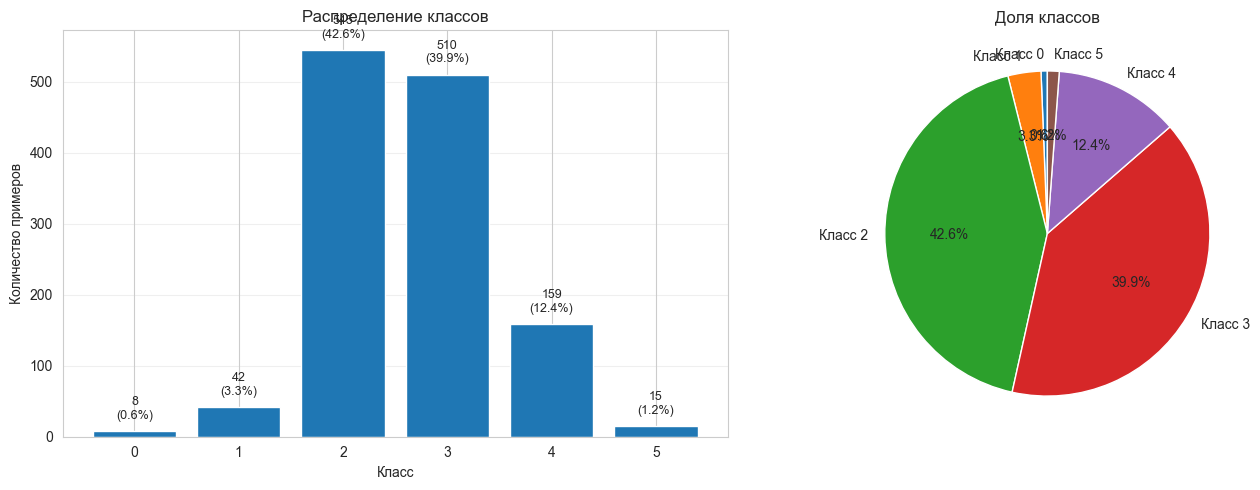


Оценка дисбаланса:
  Соотношение макс/мин: 68.12:1
  Сильный дисбаланс


In [5]:
train_dataset = data_module.train_dataset
y_train = train_dataset.y.numpy()

unique_classes, class_counts = np.unique(y_train, return_counts=True)
n_total = len(y_train)
n_classes = len(unique_classes)

print(f"Распределение классов в обучающей выборке:")
print(f"  Всего классов: {n_classes}")
print(f"  Всего примеров: {n_total}")

for cls, count in zip(unique_classes, class_counts):
    print(f"  Класс {cls}: {count} примеров ({count/n_total*100:.2f}%)")

mean_count = np.mean(class_counts)
std_count = np.std(class_counts)
cv = std_count / mean_count if mean_count > 0 else 0

print(f"\nСтатистика дисбаланса:")
print(f"  Среднее количество примеров на класс: {mean_count:.2f}")
print(f"  Стандартное отклонение: {std_count:.2f}")
print(f"  Коэффициент вариации: {cv:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(unique_classes, class_counts, color='#1f77b4')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Количество примеров')
axes[0].set_title('Распределение классов')
axes[0].grid(True, alpha=0.3, axis='y')

for cls, count in zip(unique_classes, class_counts):
    axes[0].text(cls, count + n_total*0.01, f'{count}\n({count/n_total*100:.1f}%)', 
                ha='center', va='bottom', fontsize=9)

axes[1].pie(class_counts, labels=[f'Класс {c}' for c in unique_classes], 
           autopct='%1.1f%%', startangle=90)
axes[1].set_title('Доля классов')

plt.tight_layout()
plt.show()

max_count = np.max(class_counts)
min_count = np.min(class_counts)
imbalance_ratio = max_count / min_count if min_count > 0 else float('inf')

print(f"\nОценка дисбаланса:")
print(f"  Соотношение макс/мин: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 10:
    print(f"  Сильный дисбаланс")
elif imbalance_ratio > 3:
    print(f"  Умеренный дисбаланс")
else:
    print(f"  Слабый дисбаланс")


## 5. Взвешенная loss функция

Вместо изменения данных можно использовать веса классов в функции потерь:

**class_weight** в CrossEntropyLoss: умножает потерю для каждого класса на соответствующий вес

$$L = -\frac{1}{N}\sum_{i=1}^{N}w_{y_i}\log\left(\frac{\exp(z_{i,y_i})}{\sum_{j=1}^{C}\exp(z_{i,j})}\right)$$

где $w_{y_i}$ - вес класса $y_i$.

Веса обычно вычисляются как обратно пропорциональные частоте классов:

$$w_i = \frac{n_{total}}{C \cdot n_i}$$

где $n_i$ - количество примеров класса $i$, $n_{total}$ - общее количество примеров, $C$ - количество классов.

Сравним обучение без весов и с весами классов.


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Веса классов:
  Класс 0: 26.6458
  Класс 1: 5.0754
  Класс 2: 0.3911
  Класс 3: 0.4180
  Класс 4: 1.3407
  Класс 5: 14.2111

Обучение без весов...
Epoch 0: accuracy=0.3594, f1_macro=0.0952
Epoch 0: accuracy=0.4062, f1_macro=0.0985
Epoch 1: accuracy=0.4414, f1_macro=0.1328
Epoch 2: accuracy=0.4752, f1_macro=0.1600
Epoch 3: accuracy=0.4922, f1_macro=0.1702
Epoch 4: accuracy=0.5064, f1_macro=0.1788
Epoch 5: accuracy=0.5161, f1_macro=0.1835
Epoch 6: accuracy=0.5266, f1_macro=0.1970
Epoch 7: accuracy=0.5327, f1_macro=0.2014
Epoch 8: accuracy=0.5359, f1_macro=0.2020
Epoch 9: accuracy=0.5406, f1_macro=0.2089
Epoch 10: accuracy=0.5444, f1_macro=0.2140
Epoch 11: accuracy=0.5474, f1_macro=0.2179
Epoch 12: accuracy=0.5511, f1_macro=0.2213


`Trainer.fit` stopped: `max_epochs=15` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 13: accuracy=0.5538, f1_macro=0.2244
Epoch 14: accuracy=0.5560, f1_macro=0.2266

Обучение с весами классов...
Epoch 0: accuracy=0.4219, f1_macro=0.1794
Epoch 0: accuracy=0.3058, f1_macro=0.1618
Epoch 1: accuracy=0.2669, f1_macro=0.1607
Epoch 2: accuracy=0.2675, f1_macro=0.1701
Epoch 3: accuracy=0.2777, f1_macro=0.1782
Epoch 4: accuracy=0.2911, f1_macro=0.1854
Epoch 5: accuracy=0.2886, f1_macro=0.1864
Epoch 6: accuracy=0.2965, f1_macro=0.1918
Epoch 7: accuracy=0.2950, f1_macro=0.1972
Epoch 8: accuracy=0.3012, f1_macro=0.2069
Epoch 9: accuracy=0.3101, f1_macro=0.2099
Epoch 10: accuracy=0.3147, f1_macro=0.2100
Epoch 11: accuracy=0.3191, f1_macro=0.2109
Epoch 12: accuracy=0.3202, f1_macro=0.2114
Epoch 13: accuracy=0.3225, f1_macro=0.2118


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.3281, f1_macro=0.2137

Сравнение результатов:
        name  accuracy  precision_macro  recall_macro  f1_macro  f1_weighted
0  Без весов    0.5875           0.3234        0.2572    0.2571       0.5554
1   С весами    0.4094           0.2591        0.2221    0.2272       0.4544


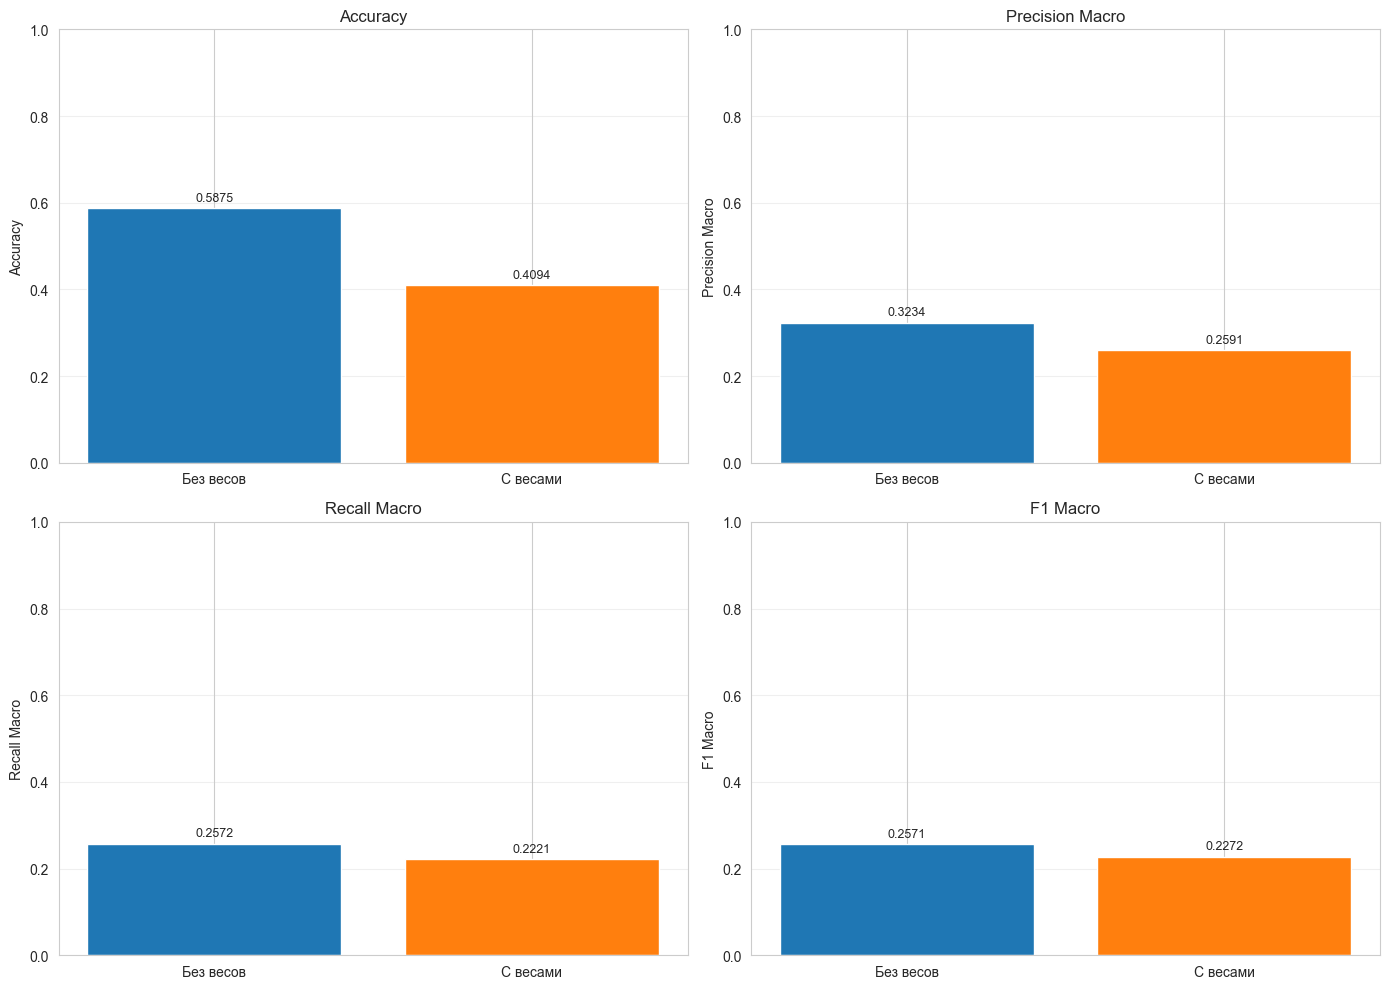

In [6]:
train_dataset = data_module.train_dataset
y_train = train_dataset.y.numpy()

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weights_tensor = torch.FloatTensor(class_weights)

print(f"Веса классов:")
for cls, weight in class_weights_dict.items():
    print(f"  Класс {cls}: {weight:.4f}")

def train_with_weights(class_weights, name):
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    
    model = MLPClassifier(
        input_dim=data_module.input_dim,
        n_classes=data_module.n_classes,
        hidden_dims=[128, 64, 32],
        activation='relu',
        dropout=0.3
    )
    
    if class_weights is not None:
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    else:
        loss_fn = nn.CrossEntropyLoss()
    
    lightning_module = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type='adam',
        learning_rate=1e-3,
        task_type='multiclass'
    )
    
    trainer = Trainer(
        max_epochs=15,
        enable_progress_bar=False,
        enable_model_summary=False
    )
    
    trainer.fit(lightning_module, train_loader, val_loader)
    
    lightning_module.eval()
    model.eval()
    
    y_true_all = []
    y_pred_all = []
    
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_true_all.append(y.numpy())
            y_pred_all.append(preds.numpy())
    
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    
    return {
        'name': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

print("\nОбучение без весов...")
results_no_weights = train_with_weights(None, 'Без весов')

print("\nОбучение с весами классов...")
results_with_weights = train_with_weights(class_weights_tensor, 'С весами')

weights_results = pd.DataFrame([results_no_weights, results_with_weights])
print("\nСравнение результатов:")
print(weights_results.round(4))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(weights_results['name'], weights_results[metric], color=['#1f77b4', '#ff7f0e'])
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    
    for bar, val in zip(bars, weights_results[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 6. Label Smoothing

Label Smoothing - техника регуляризации, которая заменяет жесткие метки (one-hot encoding) на "мягкие" метки.

Вместо метки $y = [0, 0, ..., 1, ..., 0]$ (one-hot) используем:
- Для правильного класса: $y_{smooth,i} = 1 - \alpha + \frac{\alpha}{C}$ вместо $y_i = 1$
- Для неправильных классов: $y_{smooth,j} = \frac{\alpha}{C}$ вместо $y_j = 0$

где $\alpha$ - параметр сглаживания (обычно 0.1-0.2), $C$ - количество классов.

Функция потерь с label smoothing для мультиклассовой классификации:

$$L = -\frac{1}{N}\sum_{i=1}^{N}\sum_{j=1}^{C}y_{smooth,i,j}\log(p_{i,j})$$

где $p_{i,j}$ - вероятность класса $j$ для примера $i$.

Label smoothing помогает:
- Уменьшить переобучение
- Улучшить калибровку модели
- Сделать модель более устойчивой к шуму в метках
- Смягчить чрезмерную уверенность модели

Реализуем кастомную функцию потерь с label smoothing и сравним результаты с разными значениями параметра $\alpha$.


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Обучение без label smoothing...
Epoch 0: accuracy=0.2031, f1_macro=0.0818
Epoch 0: accuracy=0.3884, f1_macro=0.1223
Epoch 1: accuracy=0.4505, f1_macro=0.1580
Epoch 2: accuracy=0.4770, f1_macro=0.1711
Epoch 3: accuracy=0.4950, f1_macro=0.1790
Epoch 4: accuracy=0.5093, f1_macro=0.1852
Epoch 5: accuracy=0.5234, f1_macro=0.2058
Epoch 6: accuracy=0.5296, f1_macro=0.2064
Epoch 7: accuracy=0.5346, f1_macro=0.2069
Epoch 8: accuracy=0.5416, f1_macro=0.2158
Epoch 9: accuracy=0.5454, f1_macro=0.2164
Epoch 10: accuracy=0.5488, f1_macro=0.2178
Epoch 11: accuracy=0.5527, f1_macro=0.2230
Epoch 12: accuracy=0.5553, f1_macro=0.2239


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 13: accuracy=0.5577, f1_macro=0.2260
Epoch 14: accuracy=0.5595, f1_macro=0.2258


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Обучение с label smoothing (α=0.1)...
Epoch 0: accuracy=0.2734, f1_macro=0.0839
Epoch 0: accuracy=0.3638, f1_macro=0.0926
Epoch 1: accuracy=0.4232, f1_macro=0.1570
Epoch 2: accuracy=0.4632, f1_macro=0.1731
Epoch 3: accuracy=0.4837, f1_macro=0.1805
Epoch 4: accuracy=0.4983, f1_macro=0.1855
Epoch 5: accuracy=0.5083, f1_macro=0.1888
Epoch 6: accuracy=0.5148, f1_macro=0.1908
Epoch 7: accuracy=0.5212, f1_macro=0.1937
Epoch 8: accuracy=0.5269, f1_macro=0.1955
Epoch 9: accuracy=0.5343, f1_macro=0.2066
Epoch 10: accuracy=0.5381, f1_macro=0.2083
Epoch 11: accuracy=0.5416, f1_macro=0.2108
Epoch 12: accuracy=0.5445, f1_macro=0.2135
Epoch 13: accuracy=0.5471, f1_macro=0.2153


`Trainer.fit` stopped: `max_epochs=15` reached.
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 14: accuracy=0.5522, f1_macro=0.2216

Обучение с label smoothing (α=0.2)...
Epoch 0: accuracy=0.3438, f1_macro=0.1048
Epoch 0: accuracy=0.4129, f1_macro=0.1076
Epoch 1: accuracy=0.4648, f1_macro=0.1469
Epoch 2: accuracy=0.4917, f1_macro=0.1663
Epoch 3: accuracy=0.5057, f1_macro=0.1759
Epoch 4: accuracy=0.5156, f1_macro=0.1816
Epoch 5: accuracy=0.5254, f1_macro=0.1944
Epoch 6: accuracy=0.5317, f1_macro=0.1991
Epoch 7: accuracy=0.5379, f1_macro=0.2044
Epoch 8: accuracy=0.5432, f1_macro=0.2119
Epoch 9: accuracy=0.5472, f1_macro=0.2182
Epoch 10: accuracy=0.5507, f1_macro=0.2238
Epoch 11: accuracy=0.5544, f1_macro=0.2265
Epoch 12: accuracy=0.5588, f1_macro=0.2329
Epoch 13: accuracy=0.5616, f1_macro=0.2367


`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: accuracy=0.5643, f1_macro=0.2391

Сравнение результатов:
              name  accuracy  precision_macro  recall_macro  f1_macro  \
0    Без smoothing    0.5844           0.3618        0.2387    0.2209   
1  Smoothing α=0.1    0.6250           0.3335        0.2900    0.2958   
2  Smoothing α=0.2    0.6031           0.3233        0.2691    0.2713   

   f1_weighted  
0       0.5340  
1       0.6021  
2       0.5735  


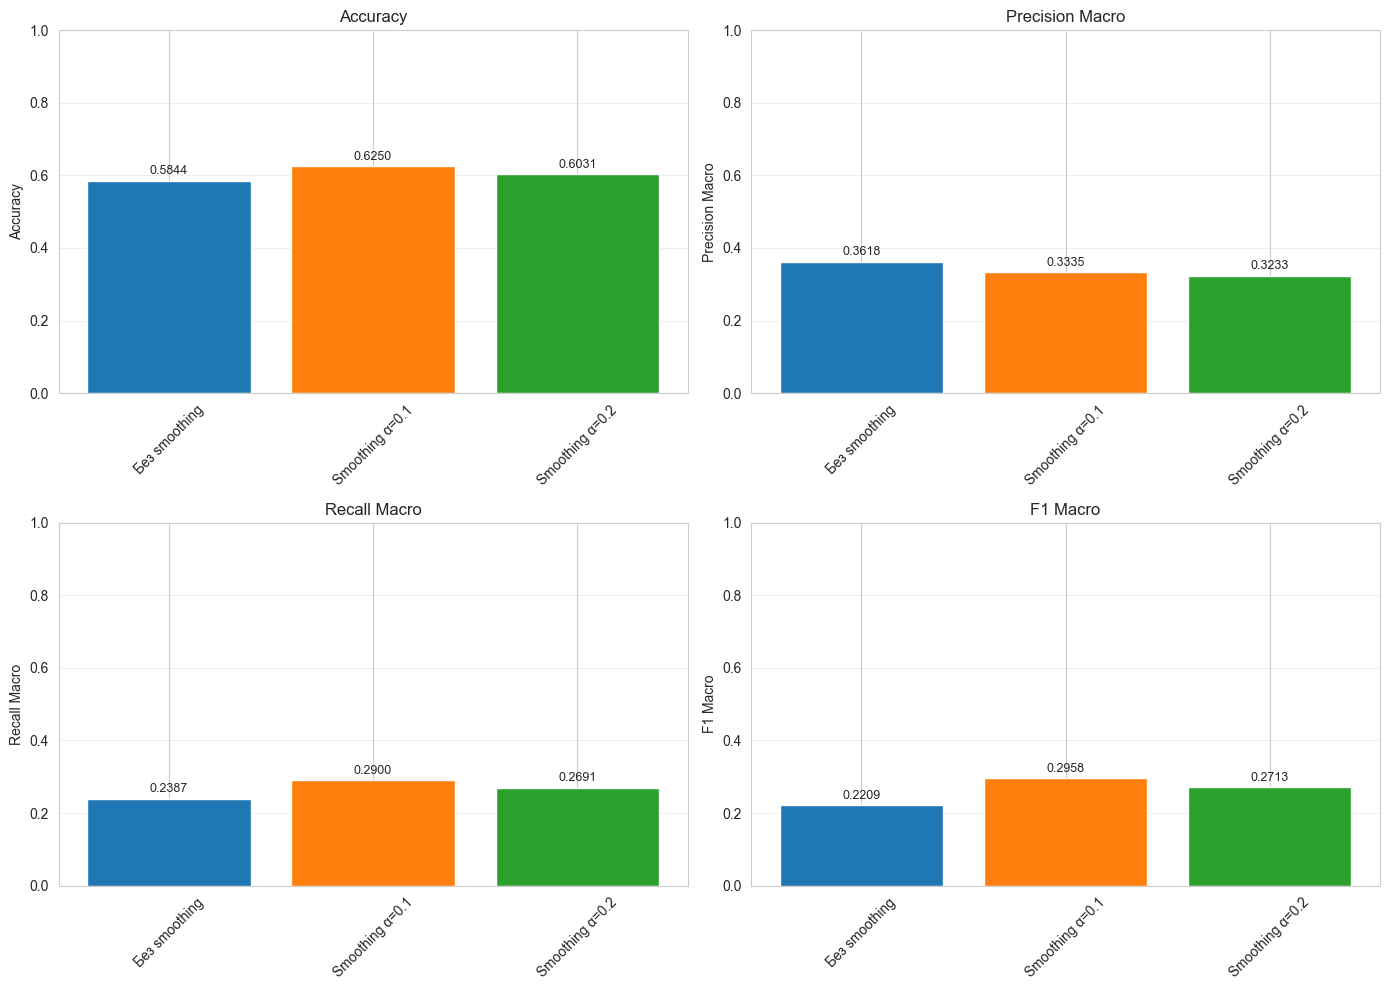

In [7]:
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1, n_classes=None):
        super().__init__()
        self.smoothing = smoothing
        self.n_classes = n_classes
    
    def forward(self, logits, targets):
        if self.n_classes is None:
            self.n_classes = logits.size(1)
        
        log_probs = F.log_softmax(logits, dim=1)
        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.n_classes - 1))
            true_dist.scatter_(1, targets.unsqueeze(1), 1.0 - self.smoothing)
        
        return torch.mean(torch.sum(-true_dist * log_probs, dim=1))

def train_with_smoothing(smoothing, name):
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()
    
    model = MLPClassifier(
        input_dim=data_module.input_dim,
        n_classes=data_module.n_classes,
        hidden_dims=[128, 64, 32],
        activation='relu',
        dropout=0.3
    )
    
    if smoothing > 0:
        loss_fn = LabelSmoothingCrossEntropyLoss(smoothing=smoothing, n_classes=data_module.n_classes)
    else:
        loss_fn = nn.CrossEntropyLoss()
    
    lightning_module = BaseLightningModule(
        model=model,
        loss_fn=loss_fn,
        optimizer_type='adam',
        learning_rate=1e-3,
        task_type='multiclass'
    )
    
    trainer = Trainer(
        max_epochs=15,
        enable_progress_bar=False,
        enable_model_summary=False
    )
    
    trainer.fit(lightning_module, train_loader, val_loader)
    
    lightning_module.eval()
    model.eval()
    
    y_true_all = []
    y_pred_all = []
    
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            y_true_all.append(y.numpy())
            y_pred_all.append(preds.numpy())
    
    y_true = np.concatenate(y_true_all)
    y_pred = np.concatenate(y_pred_all)
    
    return {
        'name': name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall_macro': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_weighted': f1_score(y_true, y_pred, average='weighted', zero_division=0)
    }

print("Обучение без label smoothing...")
results_no_smooth = train_with_smoothing(0.0, 'Без smoothing')

print("\nОбучение с label smoothing (α=0.1)...")
results_smooth_01 = train_with_smoothing(0.1, 'Smoothing α=0.1')

print("\nОбучение с label smoothing (α=0.2)...")
results_smooth_02 = train_with_smoothing(0.2, 'Smoothing α=0.2')

smoothing_results = pd.DataFrame([results_no_smooth, results_smooth_01, results_smooth_02])
print("\nСравнение результатов:")
print(smoothing_results.round(4))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(smoothing_results['name'], smoothing_results[metric], 
                  color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()}')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=45)
    
    for bar, val in zip(bars, smoothing_results[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
